Tutorial 6: Alternative Searches
================================

Up to now, we've always used the `NonLinearSearch` Dynesty and not considered the input parameters that control its
sampling. In this tutorial, we'll consider how we can change these setting to balance finding the global maxima
solution with fast run time, as well as other types of non-linear searches we can use to perform lens modeling.

In [1]:
#%matplotlib inline
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt
import autofit as af

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


we'll use new strong lensing data, where:

 - The lens galaxy's `LightProfile` is an `EllipticalSersic`.
 - The lens galaxy's total mass distribution is an `EllipticalIsothermal`.
 - The source galaxy's `LightProfile` is an `EllipticalSersic`.

In [2]:
dataset_name = "light_sersic__mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "with_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

we'll create and use a smaller 2.0" `Mask2D` again.

In [3]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=2.6
)

When plotted, the lens light's is clearly visible in the centre of the image.

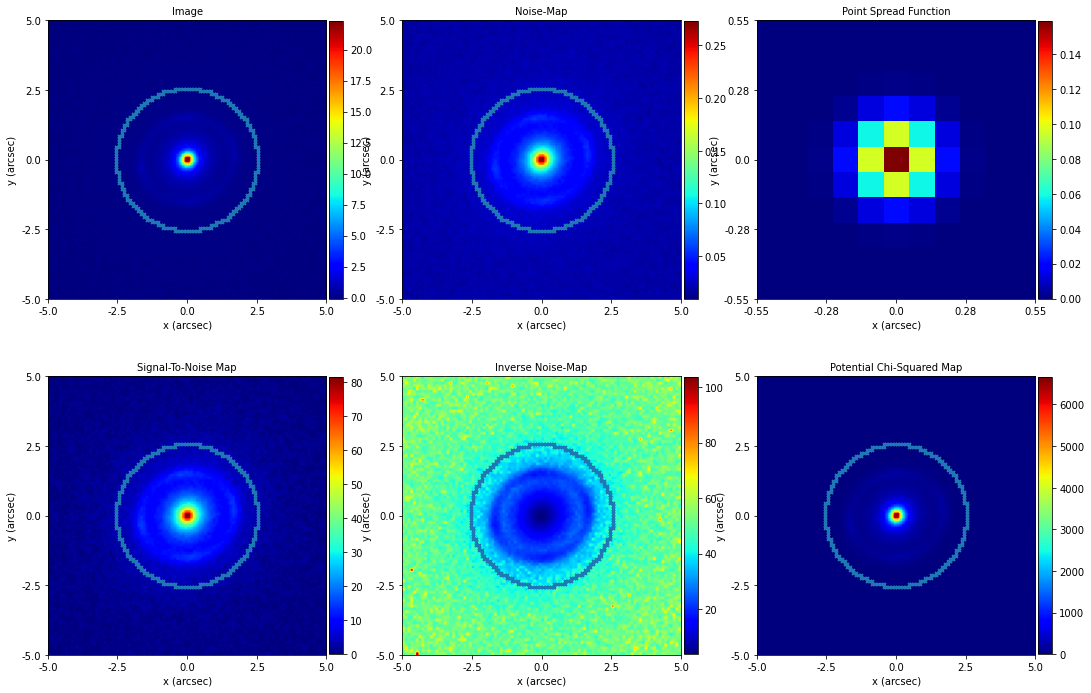

In [4]:
imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

Like in the previous tutorial, we use a `SettingsPhaseImaging` object to specify our model-fitting procedure uses a 
regular `Grid2D`.

In [5]:
settings_masked_imaging = al.SettingsMaskedImaging(grid_class=al.Grid2D, sub_size=2)

settings = al.SettingsPhaseImaging(settings_masked_imaging=settings_masked_imaging)

__Nested Sampling__

Lets first perform the model-fit using Dynesty, but look at different parameters that control how long it takes to run. 
We'll therefore discuss in a bit more detail how Dynesty works, but still keep this description conceptually simple  
and avoid technical terms and jargon. For a complete description of Dynesty you should check out the Dynesty 
publication `https://arxiv.org/abs/1904.02180`.

n_live_points:

Dynesty is a `nested sampling` algorithm. As we described in tutorial 1, it throws down a set of `live points` in 
parameter space, where each live point corresponds to a lens model with a given set of parameters. These points are
initially distributed according to our priors, hence why tuning our priors allows us to sample parameter space faster.
 
The number of live points is set by the parameter `n_live_points`. More points provide a more thorough sampling of 
parameter space, increasing the probability that we locate the global maxima solution. Therefore, if you think your 
model-fit has gone to a local maxima, you should try increasing `n_live_points`. The downside of this is Dynesty will 
take longer to sample parameter space and converge on a solution. Ideally, we will use as few live points as possible 
to locate the global maxima as quickly as possible.

evidence_tolerance:

A nested sampling algorithm estimates the *Bayesian Evidence* of the model-fit, which is quantity the non-linear 
search algorithms we introduce later do not. The Bayesian evidence quantifies how well the lens model as a whole fits
the data, following a principle called Occam's Razor (`https://simple.wikipedia.org/wiki/Occam%27s_razor`). This 
penalizes models for being more complex (e.g. more parameters) and requires that their additional complexity improve 
their overall fit to the data compared to a simpler model. By computing the comparing the Bayesian evidence of 
different models one can objectively choose the lens model that best fits the data.

A nested sampling algorithm stops sampling when it estimates that continuing sampling will not increase the Bayesian 
evidence (called the `log_evidence`) by more than the `evidence_tolerance`. As Dynesty progresses and converges on the
solution, the rate of increase of the estimated Bayesian evidence slows down. Therefore, higher `evidence_tolerance`s 
mean Dynesty terminate sooner.
    
A high `evidence_tolerance` will make the errors estimated on every parameter unreliable and its value must be kept 
below 0.8 for reliable error estimates. However, when chaining phases, we typically *do not care* about the errors 
in the first phase, therefore setting a high evidence tolerance can be an effective means to make Dynesty converge
faster (we'll estimate reliable errors in the second phase when the `evidence_tolerance is 0.8 or less). 

walks:

By default **PyAutoLens** use's Dynesty's Random Walk nested sampling (other approaches are available in Dynesty 
however our testing has revealed that the random walk sampling is best for lens modeling). In brief, in order for 
Dynesty to update the location of a live's point in parameter space, it performs a random walk from the live point's 
current location for the number of steps defined by the `walks` parameter, with the highest likelihood model chosen. 
The random walk chooses steps based on the likelihood values it evaluates, so as to try and walk towards higher 
likelihood solutions.

Therefore a `walks` of 5 will walk 5 steps, 10 will take 10 steps and so on. The choice of `walks` needs to strike a 
balance. If `walks` is too low, the random walk from each live point will not sufficiently explore parameter space 
around it and therefore fail to locate a new point with a sizeable increase in likelihood. This will slow down 
convergence around the highest likleihod solutions, but may even mean the global maxima solution is not located at all.
If `walks` is too large the walk takes longer than necessary, slowing down the code.

Through testing, we have found that `walks` = 5 - 10 is optimal for lens modeling with **PyAutoLens**. Higher values
of walks take longer to run, but are better at avoiding Dynesty inferred a local maxima as they more thoroughly
sample parameter space. The parameter `facc` controls the size of the steps the random walk takes. We have found 
**PyAutoLens** performs best for `facc` = 0.2-0.3, but feel free to experiment with these values.


Lets perform two fits, where:

 - One has many live points, a low sampling efficiency and evidence tolerance, causing the `NonLinearSearch` to
 take a long time to run (in fact, on my laptop, this run takes > 500000 iterations which translates to > 6 
 hours. So, I've commented the run function out to not waste your time, but feel free to uncomment it and run
 the phase to see this for yourself!).
      
 - One has few live points, a high sampling efficiency and evidence tolerance, causing the `NonLinearSearch` to
 converge and end quicker.

In [6]:
phase_slow = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix="howtolens",
        name="phase_t6_slow",
        n_live_points=150,
        evidence_tolerance=0.8,
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(
        lens=al.GalaxyModel(
            redshift=0.5, bulge=al.lp.EllipticalSersic, mass=al.mp.EllipticalIsothermal
        ),
        source=al.GalaxyModel(redshift=1.0, bulge=al.lp.EllipticalSersic),
    ),
)

print(
    "Dynesty has begun running - checkout the workspace/output"
    "  folder for live output of the results, images and lens model."
    "  This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

# This code (and the lines of code after) is commented out to signify the analysis runs slow, so it is optional for
# you to run this part of the tutorials.

# result_slow = phase_slow.run(dataset=imaging, mask=mask)

Dynesty has begun running - checkout the workspace/output  folder for live output of the results, images and lens model.  This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!


Lets check that we get a good model and fit to the data.

In [7]:
# aplt.FitImaging.subplot_fit_imaging(fit=result_slow.max_log_likelihood_fit)

We can use the result to tell us how many iterations Dynesty took to convergence on the solution.

In [8]:
print("Total Dynesty Iterations (If you skip running the phase, this is ~ 500000):")
# print(result_slow.samples.total_samples)

Total Dynesty Iterations (If you skip running the phase, this is ~ 500000):


Now lets run the phase with fast setting, so we can compare the total number of iterations required.

In [9]:
phase_fast = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix="howtolens", name="phase_t6_fast", n_live_points=30
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(
        lens=al.GalaxyModel(
            redshift=0.5, bulge=al.lp.EllipticalSersic, mass=al.mp.EllipticalIsothermal
        ),
        source=al.GalaxyModel(redshift=1.0, bulge=al.lp.EllipticalSersic),
    ),
)

print(
    "Dynesty has begun running - checkout the workspace/output"
    "  folder for live output of the results, images and lens model."
    "  This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

# result_fast = phase_fast.run(dataset=imaging, mask=mask)

print("Dynesty has finished run - you may now continue the notebook.")

Dynesty has begun running - checkout the workspace/output  folder for live output of the results, images and lens model.  This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!
Dynesty has finished run - you may now continue the notebook.


Lets check that this search, despite its faster sampling settings, still gives us the global maxima solution.

In [10]:
# aplt.FitImaging.subplot_fit_imaging(fit=result_fast.max_log_likelihood_fit)

And now lets confirm it uses significantly fewer iterations.

In [11]:
print("Total Dynesty Iterations:")
print("Slow settings: ~500000")
# print(result_slow.samples.total_samples)
# print("Fast settings: ", result_fast.samples.total_samples)

Total Dynesty Iterations:
Slow settings: ~500000


__Optimizers__

Nested sampling algorithms like Dynesty provides the errors on all of the model parameters, by fully mapping out all 
of the high likelihood regions of parameter space. This provides knowledge on the complete *range* of models that do 
and do not provide high likelihood fits to the data, but takes many extra iterations to perform. If we require precise 
error estimates (perhaps this is our final lens model fit before we publish the results in a paper), these extra
iterations are acceptable. 

However, we often don't care about the errors. For example, in the previous tutorial when chaining phases, the only 
result we used from the fit performed in the first phase was the maximum log likelihood model, omitting the errors
entirely! Its seems wasteful to use a nested sampling algorithm like Dynesty to map out the entirity of parameter
space when we don't use this information! 

There are a class of non-linear searches called `optimizers`, which seek to optimize just one thing, the log 
likelihood. They want to find the model that maximizes the log likelihood, with no regard for the errors, thus not 
wasting time mapping out in intricate detail every facet of parameter space. Lets see how much faster we can find a 
good fit to the lens data using an optimizer.

we'll use the `Particle Swarm Optimizer` PySwarms. Conceptually this works quite similar to Dynesty, it has a set of 
points in parameter space (called `particles`) and it uses their likelihoods to determine where it thinks the higher
likelihood regions of parameter space are. 

Unlike Dynesty, this algorithm requires us to specify how many iterations it should perform to find the global 
maxima solutions. Here, an iteration is the number of samples performed by every particle, so the total number of
iterations is n_particles * iters. Lets try a total of 50000 iterations, a factor 10 less than our Dynesty runs above. 

In [12]:
phase_pso = al.PhaseImaging(
    search=af.PySwarmsLocal(
        path_prefix="howtolens", name="phase_t6_pso", n_particles=50, iters=1000
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(
        lens=al.GalaxyModel(
            redshift=0.5, bulge=al.lp.EllipticalSersic, mass=al.mp.EllipticalIsothermal
        ),
        source=al.GalaxyModel(redshift=1.0, bulge=al.lp.EllipticalSersic),
    ),
)

print(
    "Dynesty has begun running - checkout the workspace/output"
    "  folder for live output of the results, images and lens model."
    "  This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

# result_pso = phase_pso.run(dataset=imaging, mask=mask)

print("PySwarms has finished run - you may now continue the notebook.")

# aplt.FitImaging.subplot_fit_imaging(fit=result_pso.max_log_likelihood_fit)

Dynesty has begun running - checkout the workspace/output  folder for live output of the results, images and lens model.  This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!
PySwarms has finished run - you may now continue the notebook.


It worked, and was much faster than Dynesty!

So, when should we use Dynesty and when should we use PySwarms? Its simple:

 - If we don't care about errors and want to get the global maxima solution as quickly as possible, we should use
      PySwarms.
      
 - If we want a model with robust and precise errors, we should use Dynesty.
    
There is one exception however, for complex models whose priors have not be well tuned or initialized by a previous 
phase, PySwarms has a tendancy to locate a local maxima. Dynesty`s slower but more complete sampling of parameter space 
will often find the global maxima when PySwarms doesn`t. So, if you're not happy with the results PySwarms is giving, 
it may be shrewd to bite-the-button on run-time and use Dynesty to get your initial lens model fit.

In the next chapter, when we introduce pipelines, you'll note that are our general strategy to lens modeling is to
initialize the model-fit with Dynesty, perform intermediate phases that refine the model with PySwarms and then
end with Dynesty for robust errors. Here, we choose our non-linear searches based on what result we want!

__MCMC__

For users familiar with Markov Chain Monte Carlo (MCMC) non-linear samplers, PyAutoFit supports the non-linear
search *Emcee* (af.Emcee). We have found this to be less effective at lens modeling than Dynesty and PySwarms,
but it is sill pretty successful. I've included an example run of Emcee below.

In [13]:
phase_mcmc = al.PhaseImaging(
    search=af.Emcee(
        path_prefix="howtolens", name="phase_t6_mcmc", nwalkers=50, nsteps=1000
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(
        lens=al.GalaxyModel(
            redshift=0.5, bulge=al.lp.EllipticalSersic, mass=al.mp.EllipticalIsothermal
        ),
        source=al.GalaxyModel(redshift=1.0, bulge=al.lp.EllipticalSersic),
    ),
)

print(
    "Emcee has begun running - checkout the workspace/output"
    "  folder for live output of the results, images and lens model."
    "  This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

# result_mcmc = phase_mcmc.run(dataset=imaging, mask=mask)

print("Emcee has finished run - you may now continue the notebook.")



Emcee has begun running - checkout the workspace/output  folder for live output of the results, images and lens model.  This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!
Emcee has finished run - you may now continue the notebook.
